In [2]:
#
# Run the hbv parameter estimation with full model
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/hbv_det.m
#

In [23]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd
from scipy.stats import t
from scipy.linalg import eig
import scipy.linalg as sla

In [4]:
filename = 'hbv_data.csv'
D_frame = read_file(filename, directory = 'data_sets')

read dir : /home/paperspace/learn_kipet/kipet_paresto/data_sets/hbv_data.csv


In [5]:
D_frame.shape

(50, 3)

In [6]:
D_frame.head()

,A,B,C
0.000000,1.051482,-0.000739,-0.000501
2.040816,0.718060,2.599459,371.265832
4.081633,0.641247,5.702485,325.080882
6.122449,0.657471,6.944847,296.171685
8.163265,0.772015,9.147780,291.254375


In [7]:
x = np.array([2, 0.025, 1000, 0.25, 1.9985, 7.5E-6])
np.log10(x)

array([ 0.30103   , -1.60205999,  3.        , -0.60205999,  0.30070415,
       -5.12493874])

In [14]:
builder = TemplateBuilder()    
components = {'A':1,'B':0,'C':0}
builder.add_mixture_component(components)

builder.add_parameter('lk1',initialize = 0.8, bounds=(-6.0,4.0))
builder.add_parameter('lk2',initialize = -1.1, bounds=(-6.0,4.0))
builder.add_parameter('lk3',initialize = 3.1, bounds=(-6.0,4.0))
builder.add_parameter('lk4',initialize = -0.77, bounds=(-6.0,4.0))
builder.add_parameter('lk5',initialize = -0.16, bounds=(-6.0,4.0))
builder.add_parameter('lk6',initialize = -5.46, bounds=(-6.0,4.0))

builder.add_concentration_data(D_frame)

Warning! Since C-matrix contains negative values Kipet is assuming a derivative of C has been inputted


In [15]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = 10**m.P['lk2']*m.Z[t,'B'] - 10**m.P['lk4']*m.Z[t,'A']
    exprs['B'] = 10**m.P['lk1']*m.Z[t,'A']-10**m.P['lk2']*m.Z[t,'B']-10**m.P['lk6']*m.Z[t,'B']*m.Z[t,'C']
    exprs['C'] = 10**m.P['lk3']*m.Z[t,'A']-10**m.P['lk5']*m.Z[t,'C']-10**m.P['lk6']*m.Z[t,'B']*m.Z[t,'C']
    return exprs

builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,100.0)

In [16]:
sigmas = {'A':1, 'B':100, 'C':1e4}
p_estimator = ParameterEstimator(opt_model)
p_estimator.apply_discretization('dae.collocation',nfe=50,ncp=3,scheme='LAGRANGE-RADAU')

In [17]:
options = dict()
results_pyomo = p_estimator.run_opt('k_aug',
                                    variances=sigmas,
                                  tee=True,
                                  solver_opts = options,
                                  covariance=True)

        0.11 seconds required to write file
        0.11 seconds required for presolve
Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     5103
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1356

Total number of variables............................:      909
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
T

 107  1.3017510e+06 3.29e-03 2.36e+01  -3.8 4.26e-01   1.6 1.00e+00 1.00e+00f  1
 108  1.3017368e+06 3.84e-03 3.44e+01  -3.8 3.00e-01   2.0 1.00e+00 1.00e+00f  1
 109  1.3017275e+06 5.38e-04 2.35e+01  -3.8 8.75e-02   2.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.3016963e+06 2.00e-02 5.02e+01  -3.8 4.20e-01   2.0 1.00e+00 1.00e+00f  1
 111  1.3014942e+06 5.15e-01 8.50e+02  -3.8 1.02e+00   1.5 1.00e+00 1.00e+00f  1
 112  1.3008952e+06 4.78e-02 9.31e+01  -3.8 1.22e+00   1.0 1.00e+00 1.00e+00f  1
 113  1.3000770e+06 2.19e+00 1.16e+02  -3.8 5.92e+00   0.6 1.00e+00 8.98e-01F  1
 114  1.3000772e+06 2.19e+00 1.16e+02  -3.8 2.16e+01   0.1 7.15e-02 1.10e-04h  1
 115  1.3001024e+06 2.15e+00 1.13e+02  -3.8 2.69e+01  -0.4 1.00e+00 1.92e-02h  1
 116  1.3001115e+06 2.15e+00 1.13e+02  -3.8 5.11e+01   0.0 1.44e-07 3.61e-08H  1
 117  1.3015126e+06 3.66e-01 2.30e+02  -3.8 1.20e+01  -0.4 1.54e-03 1.00e+00h  1
 118  1.3012759e+06 7.62e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.2703647e+06 1.03e+01 4.21e+02  -3.8 1.09e+00   1.0 1.00e+00 1.00e+00f  1
 221  1.2703588e+06 2.51e+01 7.24e+03  -3.8 2.46e+00   0.5 1.00e+00 1.00e+00f  1
 222  1.2697001e+06 6.83e+00 2.53e+03  -3.8 3.27e+00   0.0 1.00e+00 1.00e+00f  1
 223  1.2678782e+06 4.88e+01 2.49e+03  -3.8 7.91e+00  -0.4 1.00e+00 1.00e+00f  1
 224  1.2678706e+06 1.76e+01 8.12e+02  -3.8 3.21e-01   1.8 1.00e+00 1.00e+00h  1
 225  1.2678241e+06 4.33e+01 4.58e+03  -3.8 1.02e+00   1.3 1.00e+00 1.00e+00f  1
 226  1.2678302e+06 1.23e+01 1.40e+03  -3.8 3.85e-01   2.6 1.00e+00 1.00e+00h  1
 227  1.2678302e+06 4.64e-01 3.21e+02  -3.8 3.08e-01   2.2 1.00e+00 1.00e+00h  1
 228  1.2678135e+06 4.43e-02 1.31e+02  -3.8 6.11e-02   1.7 1.00e+00 1.00e+00f  1
 229  1.2677637e+06 2.01e-01 3.18e+01  -3.8 1.83e-01   1.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  1.2676184e+06 2.11e+00

 314  1.6623151e+05 9.10e+01 1.08e+10  -3.8 4.74e+02   5.0 1.00e+00 2.46e-03h  7
 315  1.6626689e+05 9.09e+01 1.07e+10  -3.8 9.48e+02   4.6 1.00e+00 1.43e-03h  7
 316  1.6632119e+05 9.08e+01 1.07e+10  -3.8 5.02e+02   5.0 1.00e+00 2.48e-03h  7
 317  1.6896460e+05 3.22e+02 1.09e+10  -3.8 1.08e+03   4.5 1.00e+00 8.51e-02w  1
 318  1.6897785e+05 3.22e+02 1.09e+10  -3.8 7.27e+02   4.9 1.00e+00 1.85e-04w  1
 319  1.6899290e+05 3.22e+02 2.46e+11  -3.8 2.44e+03   4.5 6.29e-01 1.05e-04w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  1.6635912e+05 9.07e+01 1.07e+10  -3.8 7.21e+02   4.9 1.00e+00 1.33e-03h  6
 321  1.6637580e+05 9.07e+01 1.07e+10  -3.8 1.71e+03   4.4 1.00e+00 4.67e-04h  8
 322  1.6643279e+05 9.06e+01 1.07e+10  -3.8 5.18e+02   4.8 1.00e+00 2.32e-03h  7
 323  1.6644963e+05 9.06e+01 1.06e+10  -3.8 2.21e+03   4.4 7.86e-01 3.82e-04h  8
 324  1.6650933e+05 9.05e+01 1.06e+10  -3.8 5.33e+02   4.8 1.00e+00 2.29e-03h  7
 325  1.6651773e+05 9.05e+01

MA27BD returned iflag=-4 and requires more memory.
 Increase liw from 149200 to 298400 and la from 228008 to 462538 and factorize again.
 411  1.3557035e+05 1.75e+02 2.16e+08  -3.8 4.85e+03   4.0 1.03e-02 4.44e-03h  2
 412  1.3605675e+05 1.75e+02 2.25e+08  -3.8 7.61e+02   3.5 1.00e+00 7.81e-03h  8
 413  1.3642041e+05 1.74e+02 2.25e+08  -3.8 9.03e+02   3.1 5.55e-03 4.76e-03h  2
 414  1.3673090e+05 1.74e+02 2.27e+08  -3.8 6.33e+02   3.5 3.27e-01 3.89e-03h  2
 415  1.3692297e+05 1.74e+02 2.28e+08  -3.8 6.19e+02   3.9 1.59e-02 2.20e-03h  2
 416  1.3695479e+05 1.74e+02 2.28e+08  -3.8 3.58e+03   3.4 2.07e-02 1.39e-04h  1
 417  1.3698791e+05 1.74e+02 2.28e+08  -3.8 7.12e+02   3.9 1.31e-01 3.03e-04h  1
 418  1.3683434e+05 1.74e+02 2.29e+08  -3.8 1.10e+04   3.4 4.19e-08 7.20e-09H  1
 419  1.3707434e+05 1.74e+02 2.44e+08  -3.8 5.98e+02   4.7 6.68e-01 2.98e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  1.3705378e+05 1.74e+02 2.44e+08  -3.8 2.60e+03 

 523r 1.3745874e+05 1.68e+01 9.99e+02   1.2 0.00e+00  -0.8 0.00e+00 9.57e-08R  2
 524r 1.3746601e+05 6.12e+05 1.58e+07   1.2 5.95e+04    -  7.52e-03 1.66e-04f  1
 525r 1.3747071e+05 5.86e+05 1.51e+07   1.2 1.03e+01   2.0 7.90e-01 4.41e-02f  1
 526r 1.3749097e+05 4.07e+05 1.05e+07   1.2 3.90e+00   2.4 2.78e-01 3.64e-01f  1
 527r 1.3754950e+05 3.56e+05 9.18e+06   1.2 1.16e+01   1.9 1.00e+00 1.34e-01f  1
 528r 1.3758883e+05 2.70e+05 6.96e+06   1.2 4.35e+00   2.4 6.87e-01 2.77e-01f  1
 529r 1.3773142e+05 2.25e+05 5.80e+06   1.2 1.30e+01   1.9 1.00e+00 1.83e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530r 1.3932898e+05 2.12e+05 5.47e+06   1.2 3.87e+01   1.4 3.72e-02 5.78e-02f  1
 531r 1.3956805e+05 1.93e+05 4.99e+06   1.2 1.43e+01   1.8 4.72e-01 9.17e-02f  1
 532r 1.3961880e+05 1.81e+05 4.68e+06   1.2 5.33e+00   2.3 1.00e+00 6.50e-02f  1
 533r 1.4020253e+05 1.47e+05 3.80e+06   1.2 1.40e+01   1.8 5.86e-01 2.07e-01f  1
 534r 1.4027243e+05 1.35e+05

 666  4.3332294e+04 2.16e-04 3.24e+00  -3.8 6.18e-02   1.7 1.00e+00 1.00e+00f  1
 667  4.3309560e+04 1.93e-03 3.23e+00  -3.8 1.85e-01   1.2 1.00e+00 1.00e+00f  1
 668  4.3242189e+04 1.69e-02 3.20e+00  -3.8 5.49e-01   0.8 1.00e+00 1.00e+00f  1
 669  4.3047219e+04 1.42e-01 2.43e+01  -3.8 1.60e+00   0.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670  4.2518623e+04 1.05e+00 1.82e+02  -3.8 4.44e+00  -0.2 1.00e+00 1.00e+00f  1
 671  4.1291659e+04 5.78e+00 1.02e+03  -3.8 1.09e+01  -0.7 1.00e+00 1.00e+00f  1
 672  3.9121267e+04 1.89e+01 3.29e+03  -3.8 2.25e+01  -1.1 1.00e+00 1.00e+00f  1
 673  3.6258350e+04 3.71e+01 5.16e+03  -3.8 3.71e+01  -1.6 1.00e+00 1.00e+00f  1
 674  3.3202732e+04 5.67e+01 3.87e+03  -3.8 7.86e+01  -2.1 1.00e+00 1.00e+00f  1
 675  3.2093702e+04 4.49e+03 2.43e+05  -3.8 5.80e+03    -  1.00e+00 1.00e+00f  1
 676  3.2367731e+04 1.91e+03 7.81e+04  -3.8 6.16e+02  -2.6 1.00e+00 1.00e+00h  1
 677  3.6138990e+04 8.68e+02

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in


[K_AUG] written by D.T. @2018

: I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 909
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 903
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 6
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.585386754490111 at var_i=450
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.585386757390813 at var_i=451
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 903, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 5103
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 1356
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 15780.470851
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 753
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[

In [18]:
print("The estimated parameters are:")
for k,v in six.iteritems(results_pyomo.P):
    print(k, v)

The estimated parameters are:
lk1 0.32307551655265676
lk2 -1.6762075197087571
lk3 2.174382887955944
lk4 -0.6717222858282669
lk5 -0.53675367420536
lk6 -5.064976249878263


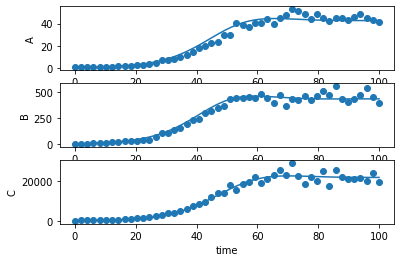

In [19]:
fig, ax = plt.subplots(3)
cmplist = ['A', 'B', 'C']
for (i, c) in enumerate(cmplist):
    ax[i].scatter(D_frame.index, D_frame[c])
    ax[i].plot(results_pyomo.Z.index, results_pyomo.Z[c])
    ax[i].set_xlabel('time')
    ax[i].set_ylabel(c)

In [20]:
results_pyomo.objective

15780.470851054002

In [21]:
# since kipet outputs reduced hessian which equals covariance if right sigma values are specified. 
# since we just specified sigma=1, we need to adjust the covariance matrix output from KIPET to get the 
# estimated covariance matrix
mse = results_pyomo.objective / (50*3 - 6)
cov_est = 2 * mse * results_pyomo.parameter_covariance
cov_est

array([[ 0.00095257, -0.00596894, -0.00062205, -0.0056943 , -0.00087417,
         0.00145695],
       [-0.00596894,  0.06057738,  0.00780377,  0.06318226,  0.00802034,
        -0.01653487],
       [-0.00062205,  0.00780377,  0.00663074,  0.00854614,  0.00654284,
        -0.00264215],
       [-0.0056943 ,  0.06318226,  0.00854614,  0.066746  ,  0.00834248,
        -0.01759593],
       [-0.00087417,  0.00802034,  0.00654284,  0.00834248,  0.00689034,
        -0.00247273],
       [ 0.00145695, -0.01653487, -0.00264215, -0.01759593, -0.00247273,
         0.00475417]])

In [24]:
eigval, eigvec = sla.eig(cov_est)
eigval, eigvec

(array([1.34379352e-01+0.j, 1.10013898e-02+0.j, 9.72852091e-04+0.j,
        1.49361433e-04+0.j, 2.31052460e-06+0.j, 4.59273527e-05+0.j]),
 array([[-0.06307685,  0.01053725, -0.62465893,  0.48979116, -0.59699895,
          0.09699673],
        [ 0.66950834, -0.10781138,  0.46687817,  0.00603945, -0.51880256,
          0.2301467 ],
        [ 0.09706093,  0.69163172, -0.24908549, -0.45284075, -0.02863722,
          0.49426341],
        [ 0.70324047, -0.0945106 , -0.43647601,  0.17900727,  0.52246646,
         -0.03153523],
        [ 0.09714642,  0.70755516,  0.2723155 ,  0.47450515,  0.03589106,
         -0.43511979],
        [-0.18540357, -0.01856535,  0.25517715,  0.54571481,  0.31520897,
          0.70922783]]))

In [25]:
eigvec[:,4]

array([-0.59699895, -0.51880256, -0.02863722,  0.52246646,  0.03589106,
        0.31520897])

In [27]:
dof = 50*3 - 6
conf_delta = t.ppf(0.975, dof) * np.sqrt(np.diag(cov_est))
conf_delta, conf_delta / np.abs(np.array(list(results_pyomo.P.values())))

(array([0.06100441, 0.486484  , 0.16095121, 0.51065304, 0.16407167,
        0.13628585]),
 array([0.18882399, 0.29022898, 0.07402156, 0.76021453, 0.30567406,
        0.0269075 ]))